In [1]:
import numpy as np
from matplotlib import pyplot as plt
import matplotlib as mpl
from scipy.optimize import fsolve
import scipy.integrate as integrate

mpl.rc('font',**{'family':'serif','serif':['Palatino']})
mpl.rc('text', usetex=True)
mpl.rcParams['axes.labelsize'] = 22
mpl.rcParams['xtick.labelsize'] = 18
mpl.rcParams['ytick.labelsize'] = 18
mpl.rcParams['axes.titlesize'] = 20


%matplotlib inline

# Better looking figures
%config InlineBackend.figure_format = 'retina'

# Make cells narrower for better typography
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:65% !important; }</style>"))

# init_printing(use_unicode=False, wrap_line=True)

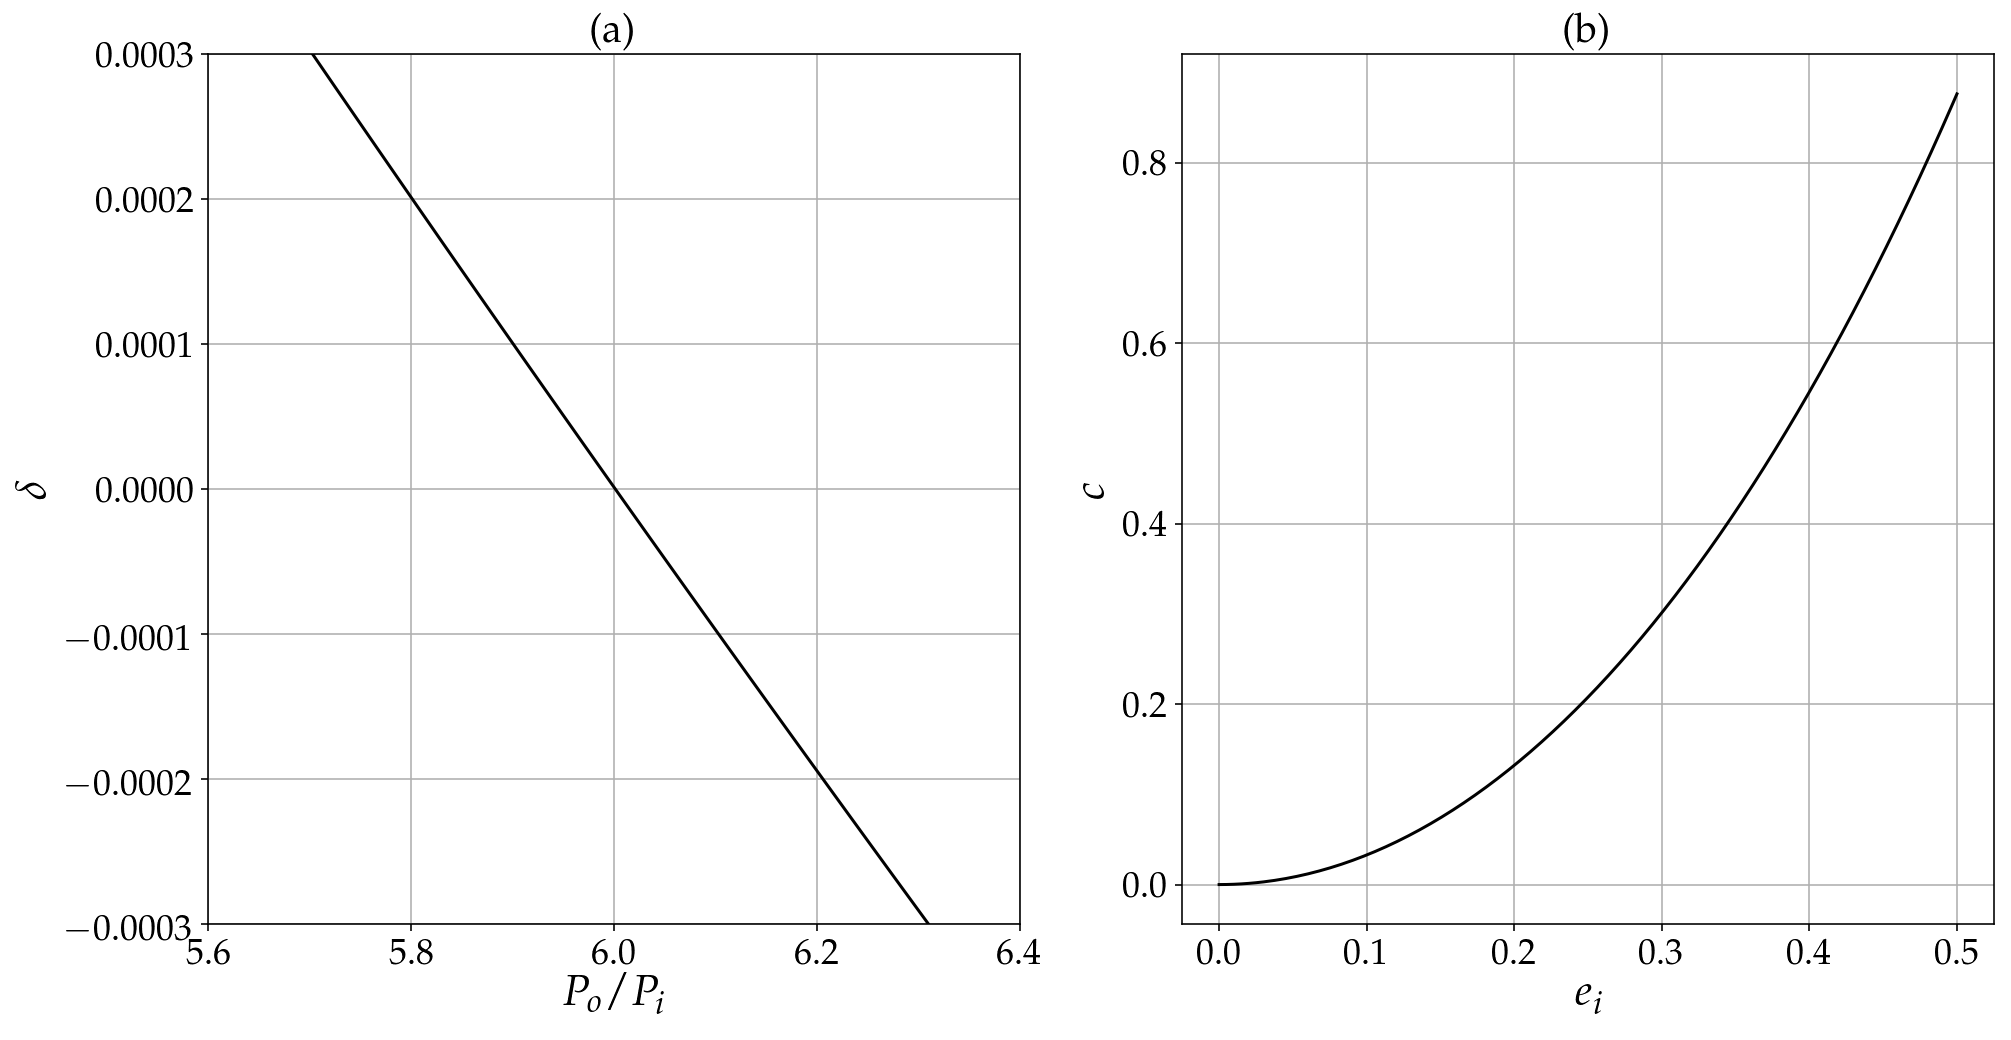

In [2]:
def constants(mu_i, mu_o, a_i, a_o, e_i, e_o):
    """
    Calculates Hamiltonian parameters from initial conditions.
    
    This function returns various constants in specified units.
    
    Parameters
    ----------
    mu_i : float
        Mass of star1+star2 in units of total mass of binary.
    mu_o : float
        Mass of star2 in units of solar masses.
    a_i : float
        Semi-major axis of inner binary in units au. 
    a_o : float
        Semi-major axis of outer binary in units au.
    e_i : float
        Eccentricity of the inner binary.
    e_o : float
        Eccentricity of the outer binary.
        
    Returns
    -------
    delta: float
        Delta parameter in the Hamiltonian.
    c: float
        c parameter in the Hamiltonian.
    """
       
    # Poincaré momenta 
    Lambda_i = mu_i # we keep this fixed
    Lambda_o = mu_o*np.sqrt(a_o) # near 6:1 resonance but not at exact location
    Gamma_i = mu_i*(1 - np.sqrt(1 - e_i**2))
    Gamma_o = mu_o*6**(1/3)*(1 - np.sqrt(1 - e_o**2))
    
    # J momenta
    J_1 = Lambda_i - m1*m2
    J_2 = Lambda_o - mu_o*6**(1/3)
        
    # Constants
    Theta_2 = J_1 + Gamma_o/4
    Theta_3 = J_2 -3*Gamma_o/2
    Theta_4 = Gamma_i - Gamma_o/4 
    
    alpha = -3*6**(2/3)/(2*mu_o) - 3/(2*mu_i)
    beta = 3*Theta_2/mu_i - 6**(2/3)*Theta_3/(2*mu_o)
    eps = 533*2**(5/6)*3**(1/3)*np.sqrt(mu_i)/(24*mu_o)
    c = (eps/alpha)**2*Theta_4
    delta = -beta*eps**2/alpha**3
    
    return delta, c   

# Initial conditions
m1 = 1. # in solar masses
m2 = .5
m3 = 1e-03
m12 = m1 + m2

period_to_a = lambda P, M: (P**2*M)**(1/3.)

P_i = 10/365 # in years
P_o = np.linspace(5.5, 6.5)*P_i # near 6:1 commensurability

a_i = period_to_a(P_i, 1) # in au
a_o = period_to_a(P_o, 1)
e_i = .3
e_o = .01

# Change mass units
m1 = m1/m12
m2 = m2/m12
mu_o = m3/m12

# Change semi-major axis units
a_o = a_o/a_i
a_i = 1 

# Mass factors
mu_i = m1*m2
mu_o = m3

# Calculate constants for use in the Hamiltonian
delta, c = constants(mu_i, mu_o, a_i, a_o, e_i, e_o)
e_i_ = np.linspace(0, 0.5, 200)

delta_, c_ = constants(mu_i, mu_o, a_i, a_o, e_i_, e_o)

fig, ax = plt.subplots(1,2 ,figsize=(16,8))
for a in ax.ravel():
    a.grid(True)
ax[0].plot(P_o/P_i, delta, 'k-')
ax[0].set_ylabel(r'$\delta$')
ax[0].set_xlabel(r'$P_o/P_i$')
ax[0].set_ylim(-0.0003, 0.0003)
ax[0].set_xlim(5.6, 6.4)
ax[0].set_title(r'(a)')
ax[1].plot(e_i_, c_, 'k-')
ax[1].set_xlabel(r'$e_i$')
ax[1].set_ylabel(r'$c$')
ax[1].set_title(r'(b)')

# plt.savefig('../figures/analytical_model/ham_params.pdf', bbox_inches='tight')

# The eccentricity kick

In [3]:
def eccentricity_kick(c, m3, e_o):
    """
    Return the eccentricity kick at 6:1 MMR crossing.
    
    Given circumbinary system parameters, the function calculates
    the change in initial eccentricity of the outer circumbinary 
    planet after 6:1 MMR crossing.
    
    Parameters
    ----------
    c : float
        The Hamiltonian parameter 'c'.
    m3: float
        Planet mass in units of (m1 + m2)
    e_o : float
        Initial eccentricity of the circumbinary planet.
    
    Returns
    -------
    e_o_final: float
        Final eccentricity of the circumbinary planet.
    """
    if not (c > 0):
        raise AssertionError('c needs to be positive.')
    
    # The 6:1 MMR Hamiltonian
    H = lambda Theta, theta, delta, c: Theta**2 - delta*Theta\
    + Theta**2*np.sqrt(Theta + c)*np.cos(theta)
    
    def find_fixed_points(delta, c, theta):
        """Solves the  equation for the fixed point."""
        
        def eq_fixed_points(Theta, *args):
            """The equation dtheta/dt = -dH/dTheta, solved for Theta."""
            delta, c , theta = args
            return (Theta**2/(2*np.sqrt(Theta + c)) + \
                2*Theta*np.sqrt(Theta + c))*np.cos(theta) + 2*Theta - delta
    
        result = fsolve(eq_fixed_points, 0.1, (delta, c, theta))
        return result[0]

    def separatrix_area(delta, c, branch):
        """Given Hamiltonian parameters, the function returns the area enclosed
        by the separatrix branch (either inner or outer)."""
        
        def eq_separatrix_zeros(Theta, *args):
            """Returns an equation defining the two points at which the separatrix 
            crosses the x axis."""
            delta, c, H_s = args
            return Theta**2*np.sqrt(Theta + c) - Theta**2 + delta*Theta + H_s    
    
        def integrand(T, *args):
            """The integrand of the integral defining the area enclosed by the separatrix."""
            delta, c, H_s = args
            return 2*((T*np.sqrt(T+c)*(-T**2+delta*T+H_s)/2+T*np.sqrt(T+c)\
             *(T+c)*(2*T-delta)+2*np.sqrt(T+c)*(T+c)*(-T**2+T*delta+H_s))\
            /(np.sqrt((T**4*(T+c)-(-T**2+delta*T+H_s)**2)/(T+c))*(T+c)**2))  
    
        if not (delta > 0):
            raise AssertionError("Delta needs to be positive, otherwise the separatrix is not defined.")

        # Calculate value position of saddle point
        T_saddle = find_fixed_points(delta, c, 0)

        if not (T_saddle > 0):
            raise AssertionError("Could not converge to a solution for Theta saddle")

        # Calculate value of H at saddle point
        H_saddle = H(T_saddle, 0, delta, c)

        # Calculate value of separatrix for theta=pi, inner branch
        T_inner = fsolve(eq_separatrix_zeros, 0., (delta, c, H_saddle))[0]
        
        if not (T_inner > 0):
            raise AssertionError("Could not converge to a solution for separatrix crossing.")

        T_outer= fsolve(eq_separatrix_zeros, 100*T_inner, (delta, c, H_saddle))[0]
        
        if not (T_outer > 0):
            raise AssertionError("Could not converge to a solution for separatrix crossing.")

        if(branch == 'inner'):
            return integrate.quad(integrand, T_saddle, T_inner, (delta, c, H_saddle))[0]
        else:
            return integrate.quad(integrand, T_saddle, T_outer, (delta, c, H_saddle))[0]
        
    def delta_transition(J_init, c):
        """Given an initial value of J, the function returns a value of delta
        for which J equals the area of the inner sepratrix."""

        def eq_delta_transition(delta_guess, *args):
            if (delta_guess < 0):
                return 1000 # Large number, force algorithm to do better
            else:
                return separatrix_area(delta_guess, c, 'inner') - J_init
    
        return fsolve(eq_delta_transition, 1e-04, (c, J_init))[0]
    
    # Calculate initial value of the momentum
    Theta_init = m3*6**(1/3)*(1 - np.sqrt(1 - e_o**2))/4
    
    J_init = 2*np.pi*Theta_init
    
    # Calculate value of delta at transiton
    delta_t = delta_transition(J_init, c)
    
    # Calculate separatrix areas for that value of delta
    J_inner = separatrix_area(delta_t, c, 'inner')    
    J_outer = separatrix_area(delta_t, c, 'outer')
            
    Theta_final = J_outer/(2*np.pi)

    ecc_from_Theta = lambda m3, G_o: (6**(2/3)/6)*np.sqrt(G_o)\
        *np.sqrt(2*6**(1/3)*m3 - G_o)/m3
        
    return ecc_from_Theta(m3, 4*Theta_final)
    

# Initial conditions
m1 = 2 # in solar masses
m2 = 1.9
m3 = 1e-02
m12 = m1 + m2

# Rescale to proper units
m1 = m1/m12
m2 = m2/m12
mu_i = m1*m2

P_i = 10/365 # doesn't matter, all the matters is the ratio
P_o = 5.6*P_i # near 6:1 commensurability

a_i = period_to_a(P_i, 1) # in au
a_o = period_to_a(P_o, 1)

# Rescale to proper units
a_o = a_o/a_i
a_i = 1 

e_i = .44
e_o = .05

# Calculate constants for use in the Hamiltonian
delta, c = constants(mu_i, mu_o, a_i, a_o, e_i, e_o)

print('delta = ', delta)
print('c = ', c)

ecc_final = eccentricity_kick(c, m3, e_o)
print(mu_i)
print('final ecc', ecc_final)

delta =  0.000492749567928
c =  0.843273344926
0.24983563445101908
final ecc 0.187169178029


In [4]:
# Initial condition
mu_o = 1e-03
e_o = 0.3

# Initilize dependent variables
n = 40
e_grid, q_grid= np.meshgrid(np.linspace(0.05, 0.4, n), np.linspace(0.05, 1, n))
mu_grid = q_grid/(1 + q_grid)**2

# Calculate value of constants
P_i = 10/365 # doesn't matter, all the matters is the ratio
P_o = 5.6*P_i # near 6:1 commensurability

a_i = period_to_a(P_i, 1) # in au
a_o = period_to_a(P_o, 1)
a_o = a_o/a_i
a_i = 1 

# Need only c, delta isn't required
delta_grid_1, c_grid_1 = constants(mu_grid, mu_o, a_i, a_o, e_grid, 0.05)
delta_grid_1, c_grid_2 = constants(mu_grid, mu_o, a_i, a_o, e_grid, 0.3)


final_ecc_1 = np.zeros((len(e_grid), len(mu_grid)))
final_ecc_2 = np.zeros((len(e_grid), len(mu_grid)))

# Iterate over each element of matrix, caluculate eccentricity kick
for i in range(len(e_grid)):
    for j in range(len(mu_grid)):
        final_ecc_1[i, j] = eccentricity_kick(c_grid_1[i, j], m3, 0.05)
        final_ecc_2[i, j] = eccentricity_kick(c_grid_2[i, j], m3, 0.3)

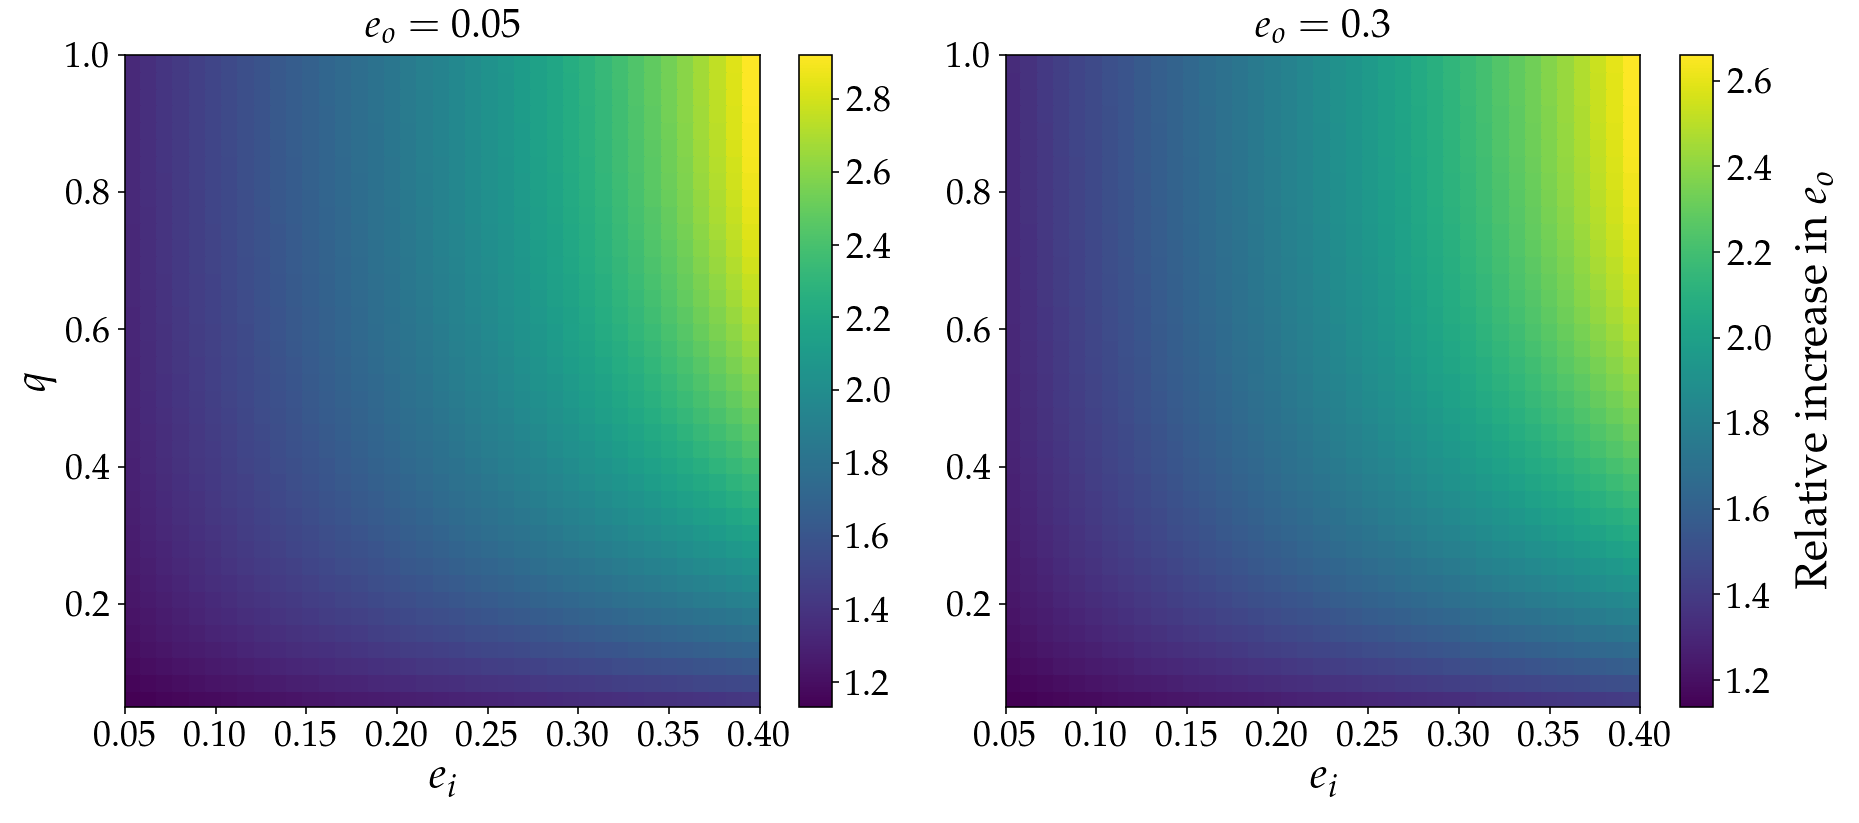

In [21]:
fig, ax = plt.subplots(1, 2, figsize=(15,6))
fig.subplots_adjust(wspace=0.11)

pcolor1 = ax[0].pcolormesh(e_grid, q_grid, final_ecc_1/0.05)
cbar1 = fig.colorbar(pcolor1, ax=ax[0])
pcolor1.set_edgecolor('face')

pcolor2 = ax[1].pcolormesh(e_grid, q_grid, final_ecc_2/0.3)
cbar2 = fig.colorbar(pcolor2, ax=ax[1])
cbar2.set_label('Relative increase in $e_o$', labelpad=15)

pcolor2.set_edgecolor('face')

for a in ax.ravel():
    a.set_xlabel(r'$e_i$')
    a.set_xticks(np.linspace(0.05, 0.4, 8))
ax[0].set_ylabel(r'$q$')
ax[0].set_title(r'$e_o =$ {0}'.format(0.05))
ax[1].set_title(r'$e_o =$ {0}'.format(0.3))
plt.savefig('../figures/analytical_model/eccentricity_kick.pdf', bbox_inches='tight')